# Fine-Tuning EfficientNet V2 on Brain MRI Data

## Install Dependencies

In [ ]:
# Uncomment the notebook if you are using Colab.
# !pip install -q lightning torchmetrics torchinfo

## Imports

In [1]:
import os
import requests
from zipfile import ZipFile
import numpy as np
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T, datasets, models
from torchvision.models import EfficientNet_V2_S_Weights

import lightning.pytorch as pl
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy, ConfusionMatrix
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torchinfo import summary

from dataclasses import dataclass

import matplotlib.pyplot as plt

from PIL import Image

In [2]:
torch.set_float32_matmul_precision('high')

## Download and Extract Dataset

In [3]:
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract zipfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

## Image Preprocess Transforms for EfficienNetV2 Small

This set of transformations includes the following steps:

- Resizing the image data to a fixed image resolution (for **EfficientNetV2-small**, the resize dimensions are **384×384**)
- Rescaling the data in the range `[0, 1]` given an unsigned int-8 image
- Normalizing the data across the `ImageNet` mean and standard deviation

In [4]:
def img_preprocess_transforms():
    preprocess = EfficientNet_V2_S_Weights.IMAGENET1K_V1.transforms()
    return preprocess

## Applying Transforms for Training and Validation Data using Custom `Dataset` class

In [5]:
class BrainMRITransforms(Dataset):
    def __init__(self, dataset, transforms, classes, class_to_idx):
        self.dataset = dataset
        self.transforms = transforms
        self.classes = classes
        self.class_to_idx = class_to_idx
        
    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        
        if self.transforms:
            image = self.transforms(image)
            
        return image, target
    
    def __len__(self):
        return len(self.dataset)

## Creating the Custom `DataModule` Class to Handle Data

In [6]:
class Brain_MRI_DataModule(pl.LightningDataModule):
    def __init__(self, img_dir, train_val_split, batch_size, num_workers, num_classes):
        super().__init__()
        self.img_dir = img_dir
        self.train_val_split = train_val_split        
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.num_classes = num_classes

        preprocess = img_preprocess_transforms()
        
        self.train_augment = T.Compose([
                                T.RandomHorizontalFlip(),
                                T.RandomRotation(degrees=10),
                                preprocess
                            ])
        
        self.valid_augment = T.Compose([
                                preprocess,
                            ])

    def prepare_data(self):
        DATASET_URL = r"https://www.dropbox.com/scl/fi/8xh03beb47jbaug5sxz44/brain_mri.zip?rlkey=c05xd8dyuzz8ev5scacwcnlzt&dl=1"
        DATA_ZIP_FILE = f"brain_mri.zip"
        DATASET_DIR = self.img_dir
        DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATA_ZIP_FILE}.zip")
        
        # Download if dataset does not exists.
        if not os.path.exists(DATASET_DIR):
            download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
            os.remove(DATASET_ZIP_PATH)
        
    def setup(self, *args, **kwargs):
        
        image_dataset = datasets.ImageFolder(root=self.img_dir)
        mri_classes = image_dataset.classes
        cls_to_idx = image_dataset.class_to_idx
        
        train_set, val_set = random_split(image_dataset, self.train_val_split)
        
        # Create train set after split.
        self.train_dataset = BrainMRITransforms(
                                dataset = train_set,
                                transforms = self.train_augment,
                                classes = mri_classes,
                                class_to_idx = cls_to_idx
                                )

        # Create validation set after split.
        self.val_dataset = BrainMRITransforms(
                                dataset = val_set,
                                transforms = self.valid_augment,
                                classes = mri_classes,
                                class_to_idx= cls_to_idx
                                )

        # Create csv file for validation data for inference later on.
        # -----------------------------------------------------------

        csv_filename = "validation_samples.csv"
        # Fields of CSV files for creating validation samples.
        fields = ["Filename", "Target"]
        
        # Index the filenames and targets from image_dataset based on val-split.
        val_samples = [image_dataset.samples[idx] for idx in val_set.indices]

        # Create csv file.
        with open(csv_filename, "w", newline="") as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow(fields)
            csv_writer.writerows(val_samples)


    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size = self.batch_size,
                          num_workers = self.num_workers,
                          shuffle = True,
                          pin_memory=True
                          )

    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size = self.batch_size,
                          num_workers = self.num_workers,
                          shuffle = False,
                          pin_memory=True
                          )

## Hyperparameter Configuration

### Data Configuration

In [7]:
@dataclass(frozen=True)
class DataConfiguration:
    data_root: str = f"data"
    num_workers: int = 4
    batch_size: int = 32
    train_val_split: tuple = (0.8, 0.2)
    num_classes = 4

### Training Configuration

In [8]:
@dataclass(frozen=True)
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    epochs: int = 25
    blocks_to_ft: int = 2
    optimizer: str = "Adam"
    lr: float = 1e-4  # initial learning rate for lr scheduler
    weight_decay: float = 5e-4
    train_logs: str = "EffNet-FT-Logs"
    precision: str = "16-mixed"

In [9]:
data_config = DataConfiguration()
train_config = TrainingConfiguration()

## Visualize Data

In [10]:
np.random.seed(42)
torch.manual_seed(42)
    
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

data_module_test = Brain_MRI_DataModule(
                        img_dir=data_config.data_root,
                        train_val_split=data_config.train_val_split,
                        batch_size=data_config.batch_size,
                        num_classes=data_config.num_classes,
                        num_workers=data_config.num_workers
                    )

# Download data.
data_module_test.prepare_data()

# Create train and validation sets.
data_module_test.setup()

train_loader = data_module_test.train_dataloader()

idx_to_class =  {v:k for k,v in train_loader.dataset.class_to_idx.items()}

### Visualize Training Data

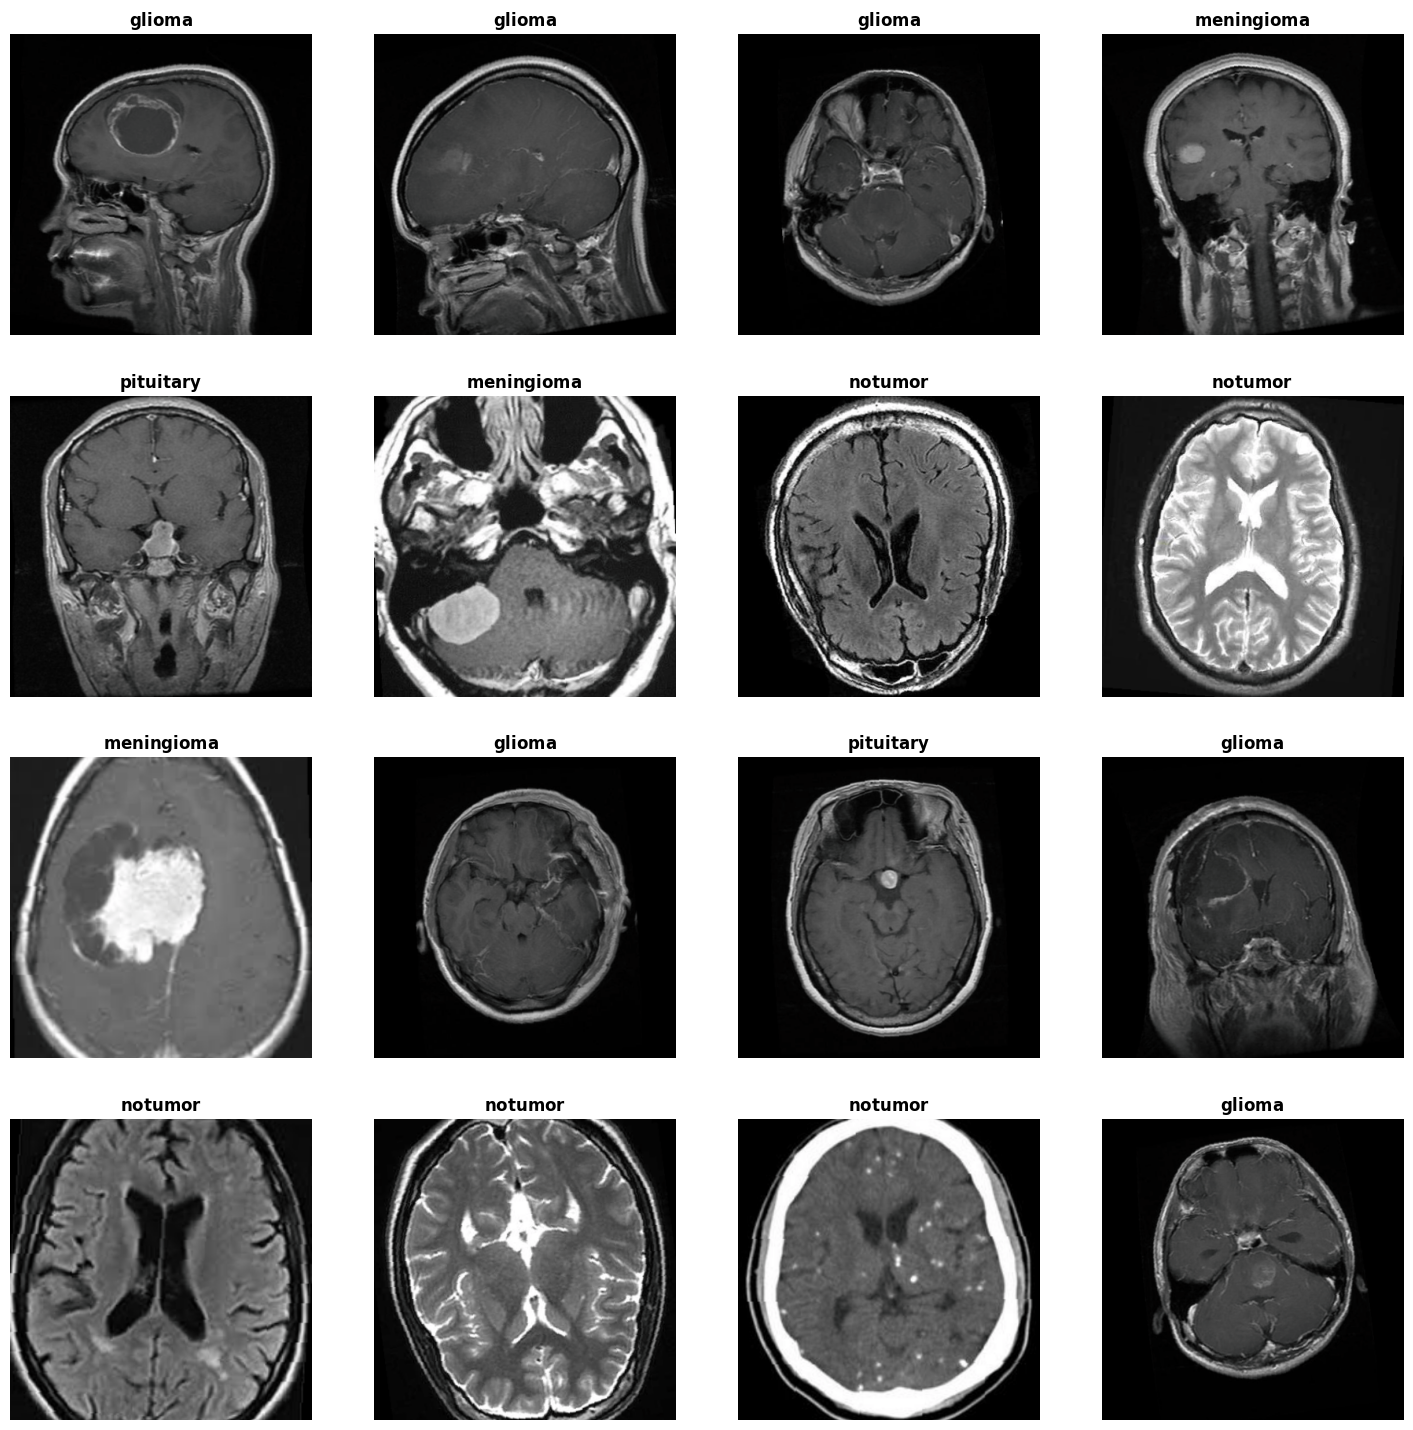

In [11]:
train_img_batch, train_target_batch = next(iter(train_loader))

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

plt.figure(figsize=(18, 18))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 4

    
for idx in range(num_rows*num_cols):
    
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    
    img_tensor_denorm = (train_img_batch[idx]*std[:,None,None] + mean[:,None,None]).clamp(min=0., max=1.)
    pil_image = T.functional.to_pil_image(img_tensor_denorm)
    plt.imshow(pil_image)
    plt.title(r"$\bf{"+idx_to_class[int(train_target_batch[idx])]+"}$")
    plt.axis("off")

## EfficientNetV2 small Fine-Tuning

- We fine-tune only the last `k` bocks in the feature extractor of EfficientNetv2 given by the paarmeter: `last_k_blocks_ft`
- The `FC` Layer is modified according to the number of classes in the dataset.

In [12]:
def fine_tune_effnet_v2_s(last_k_blocks_ft=1, num_classes=4):
    
    effnet_v2s = models.efficientnet_v2_s(weights="DEFAULT")
    
    for param in effnet_v2s.parameters():
        param.requires_grad = False

    # Fine-tune the last 2 Sequential blocks.
    for params in effnet_v2s.features[-last_k_blocks_ft:].parameters():
        params.requires_grad = True
        
    last_conv_out_channels = effnet_v2s.classifier[-1].in_features

    # Update the classifier block.
    effnet_v2s.classifier[-1] = nn.Linear(in_features=last_conv_out_channels,
                                          out_features=num_classes)

    
    return effnet_v2s

### Display Model Summary

In [13]:
model = fine_tune_effnet_v2_s(last_k_blocks_ft=2, num_classes=4)
print(summary(model, input_size=(1,3, 384, 384), device="cpu", depth=2, row_settings=["var_names"]))

Layer (type (var_name))                                      Output Shape              Param #
EfficientNet (EfficientNet)                                  [1, 4]                    --
├─Sequential (features)                                      [1, 1280, 12, 12]         --
│    └─Conv2dNormActivation (0)                              [1, 24, 192, 192]         (696)
│    └─Sequential (1)                                        [1, 24, 192, 192]         (10,464)
│    └─Sequential (2)                                        [1, 48, 96, 96]           (303,552)
│    └─Sequential (3)                                        [1, 64, 48, 48]           (589,184)
│    └─Sequential (4)                                        [1, 128, 24, 24]          (917,680)
│    └─Sequential (5)                                        [1, 160, 24, 24]          (3,463,840)
│    └─Sequential (6)                                        [1, 256, 12, 12]          14,561,832
│    └─Conv2dNormActivation (7)                 

/home/kunal/miniconda3/envs/pytorch_2_0_0/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/kunal/miniconda3/envs/pytorch_2_0_0/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


## Creating Custom `LightningModule` Class For Training and Evaluation

In [14]:
class Fine_Tune_EffNet(pl.LightningModule):
    def __init__(
        self,
        num_classes: int = 4,
        fine_tune_last_k_blocks: int = 1,
        init_lr: float = 0.1,
        optimizer_name: str = "SGD",
        weight_decay: float = 1e-4,
        num_epochs: int = 100,
    ):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = fine_tune_effnet_v2_s(last_k_blocks_ft=self.hparams.fine_tune_last_k_blocks,
                                           num_classes=self.hparams.num_classes)

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")

    def forward(self, data):
        
        logits = self.model(data)
        return logits

    
    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)

        # calculate batch loss
        loss = F.cross_entropy(logits, target)

        # Batch Predictions.
        pred_batch = logits.detach().argmax(dim=1)
        
        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_acc(pred_batch, target)

        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=True)
        self.log("train/batch_acc", self.mean_train_acc, prog_bar=True, logger=True)
        
        return loss
        

    def on_train_epoch_end(self):
        
        # Computing and logging the training mean loss & mean f1.
        self.log("train/loss", self.mean_train_loss, prog_bar=True, logger=True)
        self.log("train/acc", self.mean_train_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)
        

    def validation_step(self, batch, *args, **kwargs):
        
        data, target = batch
        logits = self(data)
        
        # calculate batch loss
        loss = F.cross_entropy(logits, target)

        # Batch Predictions.
        pred_batch = logits.argmax(dim=1)

        self.mean_valid_loss(loss, weight=data.shape[0])
        self.mean_valid_acc(pred_batch, target)
        

    def on_validation_epoch_end(self):
        
        # Computing and logging the validation mean loss & mean f1.
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True, logger=True)
        self.log("valid/acc", self.mean_valid_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer_name)(
            self.model.parameters(),
            lr=self.hparams.init_lr,
            weight_decay=self.hparams.weight_decay,
        )

        return optimizer

## Fine-tuning and Training

In [15]:
data_config = DataConfiguration()
train_config = TrainingConfiguration()

In [16]:
# Seed everything for reproducibility.
pl.seed_everything(42, workers=True)

# Initiate the DataModule class.
data_module = Brain_MRI_DataModule(
                        img_dir=data_config.data_root,
                        train_val_split=data_config.train_val_split,
                        batch_size=data_config.batch_size,
                        num_classes=data_config.num_classes,
                        num_workers=data_config.num_workers
                    )

# Initiate the LightningModule class.
model = Fine_Tune_EffNet(
            num_classes=data_config.num_classes,
            fine_tune_last_k_blocks=train_config.blocks_to_ft,
            init_lr=train_config.lr,
            optimizer_name=train_config.optimizer,
            weight_decay=train_config.weight_decay,
            num_epochs=train_config.epochs
        )

Seed set to 42


### TensorBoard and Checkpointing Callbacks

In [17]:
model_checkpoint = ModelCheckpoint(
    monitor="valid/acc",
    mode="max",
    filename="effnetv2_s_{epoch:03d}",
    auto_insert_metric_name=False,
    save_weights_only=True,
)

tb_logger = TensorBoardLogger(save_dir=train_config.train_logs, name=train_config.train_logs)

### Perform Training

In [18]:
# Initializing the Trainer class object.
trainer = pl.Trainer(
    accelerator="auto",  
    devices="auto",  
    strategy="auto", 
    max_epochs=train_config.epochs,  # Maximum number of epoch to train for.
    enable_model_summary=True,  # Disable printing of model summary as we are using torchinfo.
    callbacks=[model_checkpoint],  # Declaring callbacks to use.
    precision=train_config.precision,  # Using Mixed Precision training.
    logger=tb_logger
)

# Start training
trainer.fit(model, data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: EffNet-FT-Logs/EffNet-FT-Logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | model           | EfficientNet       | 20.2 M
1 | mean_train_loss | MeanMetric         | 0     
2 | mean_train_acc  | MulticlassAccuracy | 0     
3 | mean_valid_loss | MeanMetric         | 0     
4 | mean_valid_acc  | MulticlassAccuracy | 0     
-------------------------------------------------------
14.9 M    Trainable params
5.3 M     Non-trainable params
20.2 M    Total params
80.730    Total estimated model params size (MB)


Sanity Checking: |                                                            | 0/? [00:00<?, ?it/s]

/home/kunal/miniconda3/envs/pytorch_2_0_0/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('step', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
/home/kunal/miniconda3/envs/pytorch_2_0_0/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                   | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

/home/kunal/miniconda3/envs/pytorch_2_0_0/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:211: You called `self.log('step', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.


Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                                                 | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


## Model Inference and Visualizations

### De-Normalize Image Tensor using ImageNet Mean and Std

In [19]:
def denormalize(img_tensor,
                mean = torch.tensor([0.485, 0.456, 0.406]),
                std = torch.as_tensor([0.229, 0.224, 0.225])):

    denorm_image = (img_tensor * std[:,None,None] + mean[:,None,None]).clamp(min=0., max=1.)

    return denorm_image

### Perform Model Inference on Batch Data

In [20]:
def batch_prediction(model, image_batch, device="cpu"):

    # freeze model for inference
    model.freeze()

    # Transfer model to CPU.
    model.to(device)
    
    # run model in evaluation mode
    model.eval()

    with torch.no_grad():
        output_logits = model(image_batch.to(device))

    # get probability score using softmax
    prob = F.softmax(output_logits, dim=1)

    # get the max probability and class_id.
    pred_prob, pred_cls = prob.max(dim=1)

    # Convert predictions to lists
    pred_cls_batch = pred_cls.cpu().tolist()
    pred_prob_batch = pred_prob.cpu().tolist()

    return pred_cls_batch, pred_prob_batch

### Model Inference on Validation Data

In [21]:
def sample_prediction(data_module, ckpt_path, device="cpu"):

    # load model from checkpoint
    ckpt_model = Fine_Tune_EffNet.load_from_checkpoint(ckpt_path)
    
    # get val_dataloader for data_module
    val_data_batch = next(iter(data_module.val_dataloader()))

    # Image batch
    image_batch = val_data_batch[0]

    # GT batch.
    target_batch = val_data_batch[1]  
    
    pred_cls_batch, pred_prob_batch = batch_prediction(model, image_batch.to(device), device)
    
    denorm_imgs = []
    denorm_imgs.extend([np.asarray(T.functional.to_pil_image(image)) for image in denormalize(image_batch)])


    plt.figure(figsize=(15, 30))

    for idx, (img, true, pred, prob) in enumerate(zip(denorm_imgs, target_batch, pred_cls_batch, pred_prob_batch), 1):
        # img = np.array(img).reshape(32, 32)
        ax = plt.subplot(8, 4, idx)
        plt.imshow(img)
        title = f"GT:{idx_to_class[int(true)]}, Pred:{idx_to_class[pred]}({prob:.1f})"
        title_obj = plt.title(title)
        
        if pred == true:
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")
        plt.axis("off")
    
    plt.show()

    return

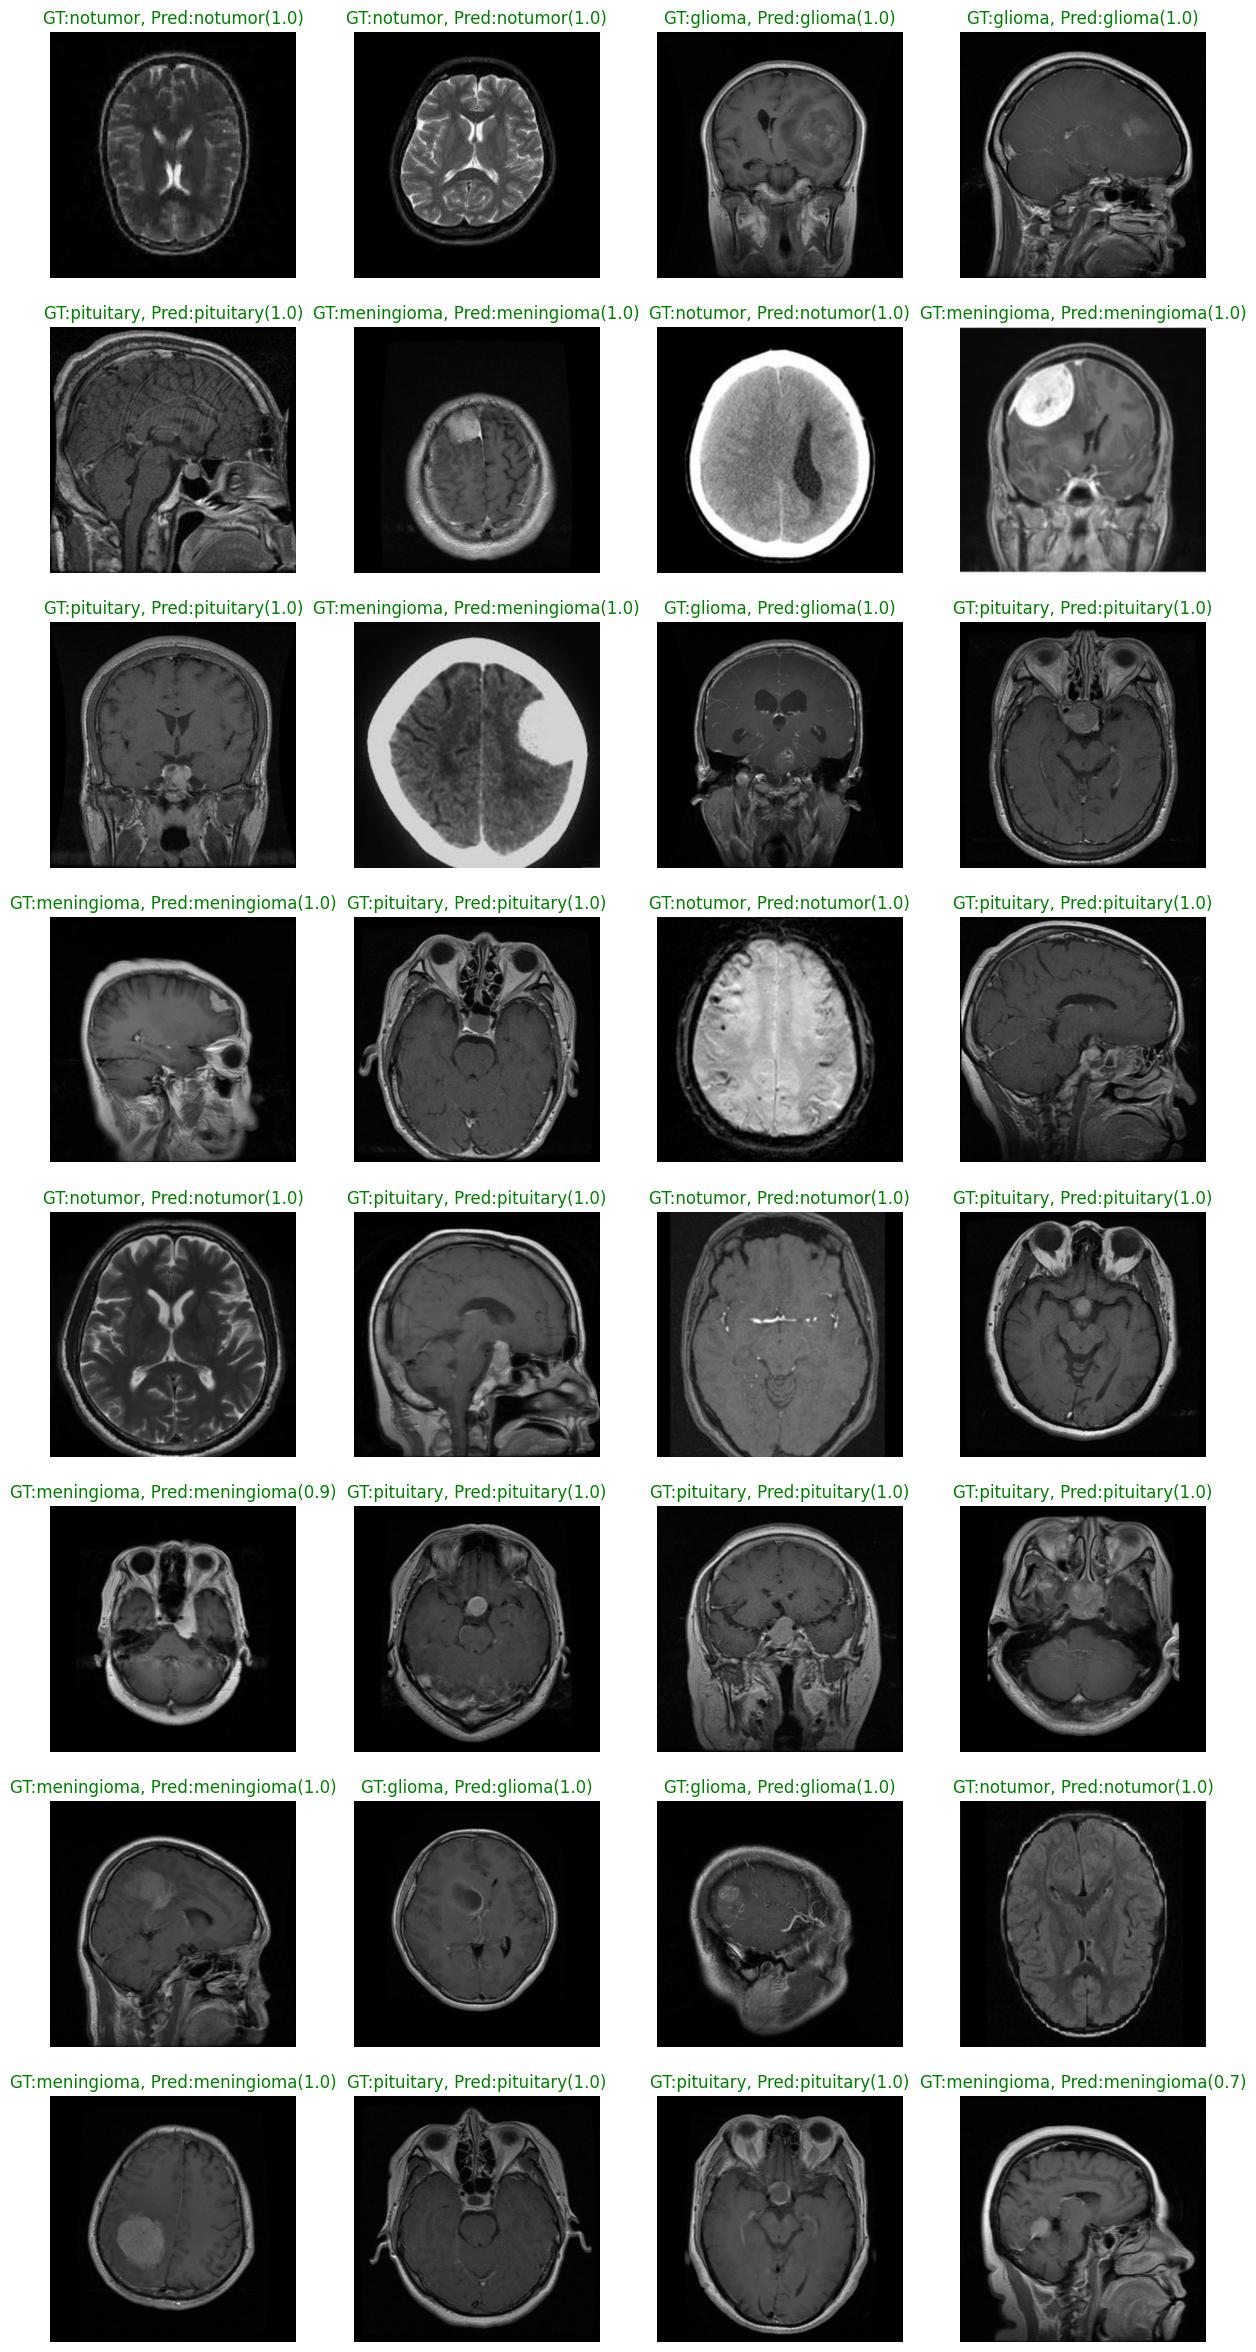

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

sample_prediction(data_module, model_checkpoint.best_model_path, device)